In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# changing location to my drive
!cd /content/drive/MyDrive

Extracting files from zip

In [ ]:
from zipfile import ZipFile

with ZipFile('/content/drive/MyDrive/dogs-vs-cats.zip','r') as zipobj:
  # extract all the content of zip file in current directory.
  zipobj.extractall()

with ZipFile('train.zip','r') as zipobj:
  # extract all the content of zip file in current directory.
  zipobj.extractall()

with ZipFile('test1.zip','r') as zipobj:
  # extract all the content of zip file in current directory.
  zipobj.extractall()

Creating sub directories

In [ ]:
# create directories
from os import makedirs
dataset_home='dataset_dogs_vs_cats/'
subdirs=['train/','test/']
for subdir in subdirs:
  #create label subdirectories
  labeldirs= ['dogs/','cats/']
  for labldir in labeldirs:
    newdir= dataset_home + subdir + labldir
    makedirs(newdir,exist_ok=True)

Changing the dataset to fit this format.

In [ ]:
from os import makedirs
from os import listdir
from shutil import copyfile
#create directories
from random import seed, random
seed(1)
# % of pictures to use for validation
val_ratio=0.25
# copying images data into the created subdirectories
src_directory= 'train'
dataset_home='dataset_dogs_vs_cats/'
for file in listdir(src_directory):
  src= src_directory + '/'+ file
  dst_dir='train/'
  if random()< val_ratio: # to randomly divide images to the train and test folders.
    dst_dir='test/'
  if file.startswith('cat'):
    dst= dataset_home + dst_dir + 'cats/'+ file
    copyfile(src,dst)
  elif file.startswith('dog'):
    dst= dataset_home + dst_dir + 'dogs/'+ file
    copyfile(src,dst)

Prepare a model for transfer learning

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

model= VGG16(include_top=False, input_shape=(224,224,3)) # false value means dont include the layers present after the flaten layer, those layers will be trained by me. it signifies that we are doing transfer learning.

# mark loaded layers as not trainable(i.e layers before the flatten layer)
for layer in model.layers:
  layer.trainable=False

# add new classifier layers
flat1= Flatten()(model.layers[-1].output)
class1= Dense(128,activation ='relu', kernel_initializer='he_uniform')(flat1)
output= Dense(1, activation='sigmoid')(class1)

# define new model
model= Model(inputs=model.inputs, outputs=output)

#compile model
opt= SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

58900480/58889256 [==============================] - 1s 0us/step


Run the model using generator

In [ ]:
datagen= ImageDataGenerator(featurewise_center=True) # generator helps loading images into RAM in batches.
# specify imagenet mean values for centering
datagen.mean=[123.68,116.779,103.939]
#prepare iterator by taking all images from directory in batches.
train_it= datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
                                      class_mode='binary', batch_size=64, target_size=(224,224))
test_it= datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
                                      class_mode='binary', batch_size=64, target_size=(224,224))
# fit model
history= model.fit_generator(train_it, steps_per_epoch= len(train_it), validation_data= test_it,
                             validation_steps=len(test_it), epochs=5, verbose=1)

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
293/293 [==============================] - 239s 665ms/step - loss: 0.3563 - accuracy: 0.9604 - val_loss: 0.0737 - val_accuracy: 0.9716
Epoch 2/5
293/293 [==============================] - 181s 616ms/step - loss: 0.0310 - accuracy: 0.9891 - val_loss: 0.0665 - val_accuracy: 0.9760
Epoch 3/5
293/293 [==============================] - 181s 616ms/step - loss: 0.0113 - accuracy: 0.9964 - val_loss: 0.0791 - val_accuracy: 0.9748
Epoch 4/5
293/293 [==============================] - 181s 617ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 0.0893 - val_accuracy: 0.9756
Epoch 5/5
293/293 [==============================] - 181s 618ms/step - loss: 0.0016 - accuracy: 0.9998 - val_loss: 0.0969 - val_accuracy: 0.9756


Plot the loss and accuracy

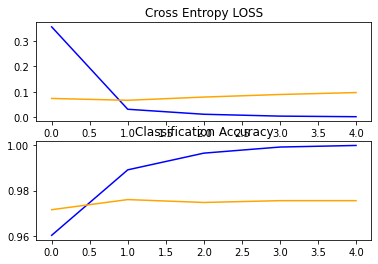

In [ ]:
import matplotlib.pyplot as pyplot
import sys
pyplot. subplot (211)
pyplot.title('Cross Entropy LOSS')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')
# plot accuracy
pyplot. subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
#save plot to file
filename = sys.argv[0].split('/')[-1]
pyplot.savefig(filename + '_plot.png')

Saving the model

In [ ]:
model.save('/content/drive/MyDrive/cat_dog_model.h5')

In [ ]:
from keras.models import load_model
model = load_model('cat_dog_model.h5')

OSError: ignored

Predict output from the model

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
# load and prepare the image
#load the image
img = load_img('/content/dataset_dogs_vs_cats/test/dogs/dog.100.jpg', target_size=(224, 224))
# convert to array
img = img_to_array(img)
# reshape into a single sample with 3 channels
img = img.reshape(1, 224, 224, 3)
# center pixel data
img = img.astype('float32')
img = img - [123.68, 116.779, 193.939] # subtracting the data generator mean from it.

In [ ]:
#1 is for dogs and 0 for cats
result = model.predict(img)
print (result[0])


[1.]
